In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data
sales = pd.read_csv("/content/hk_sales_data.csv")
weather = pd.read_csv("/content/2024_weather_data.csv")

sales['date'] = pd.to_datetime(sales['Sent Date']).dt.date
sales['time'] = pd.to_datetime(sales['Sent Date']).dt.time
weather['date'] = pd.to_datetime(weather['datetime']).dt.date

sales = sales[sales["Net Price"] >= 1]
sales = pd.merge(sales, weather, on='date', how='left')
sales = sales[sales["Void?"] == False]

sales = sales.drop([
    "Menu Item", "Sent Date", "description", "name", "icon",
    "datetime", "stations", "Void?", "sunrise", "sunset", "conditions"
], axis=1)

sales['datetime'] = pd.to_datetime(sales['date'].astype(str) + ' ' + sales['time'].astype(str))
sales.set_index('datetime', inplace=True)
sales["sale"] = sales['Net Price'] * sales["Qty"]

alc_sales = sales[sales['Menu'] == 'BEVERAGES']
alc_sales = alc_sales[alc_sales['Menu Group'] != 'NA Beverages']
food_sales = sales[sales['Sales Category'] == 'Food']

alc_sales = alc_sales.select_dtypes(include=['number'])
food_sales = food_sales.select_dtypes(include=['number'])

alc_sales_resampled = alc_sales.resample('1h').sum()
food_sales_resampled = food_sales.resample('1h').sum()

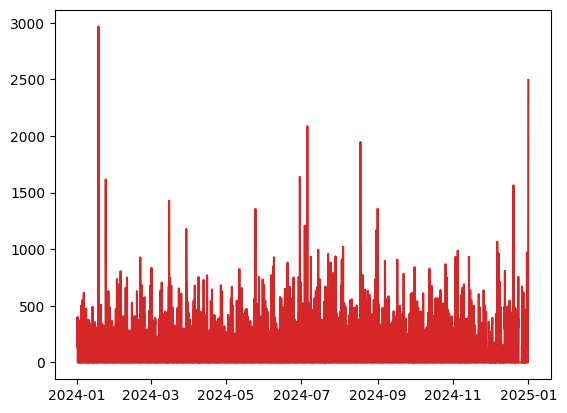

In [3]:
plt.plot(alc_sales_resampled.index, alc_sales_resampled['sale'], color='tab:red')
plt.show()

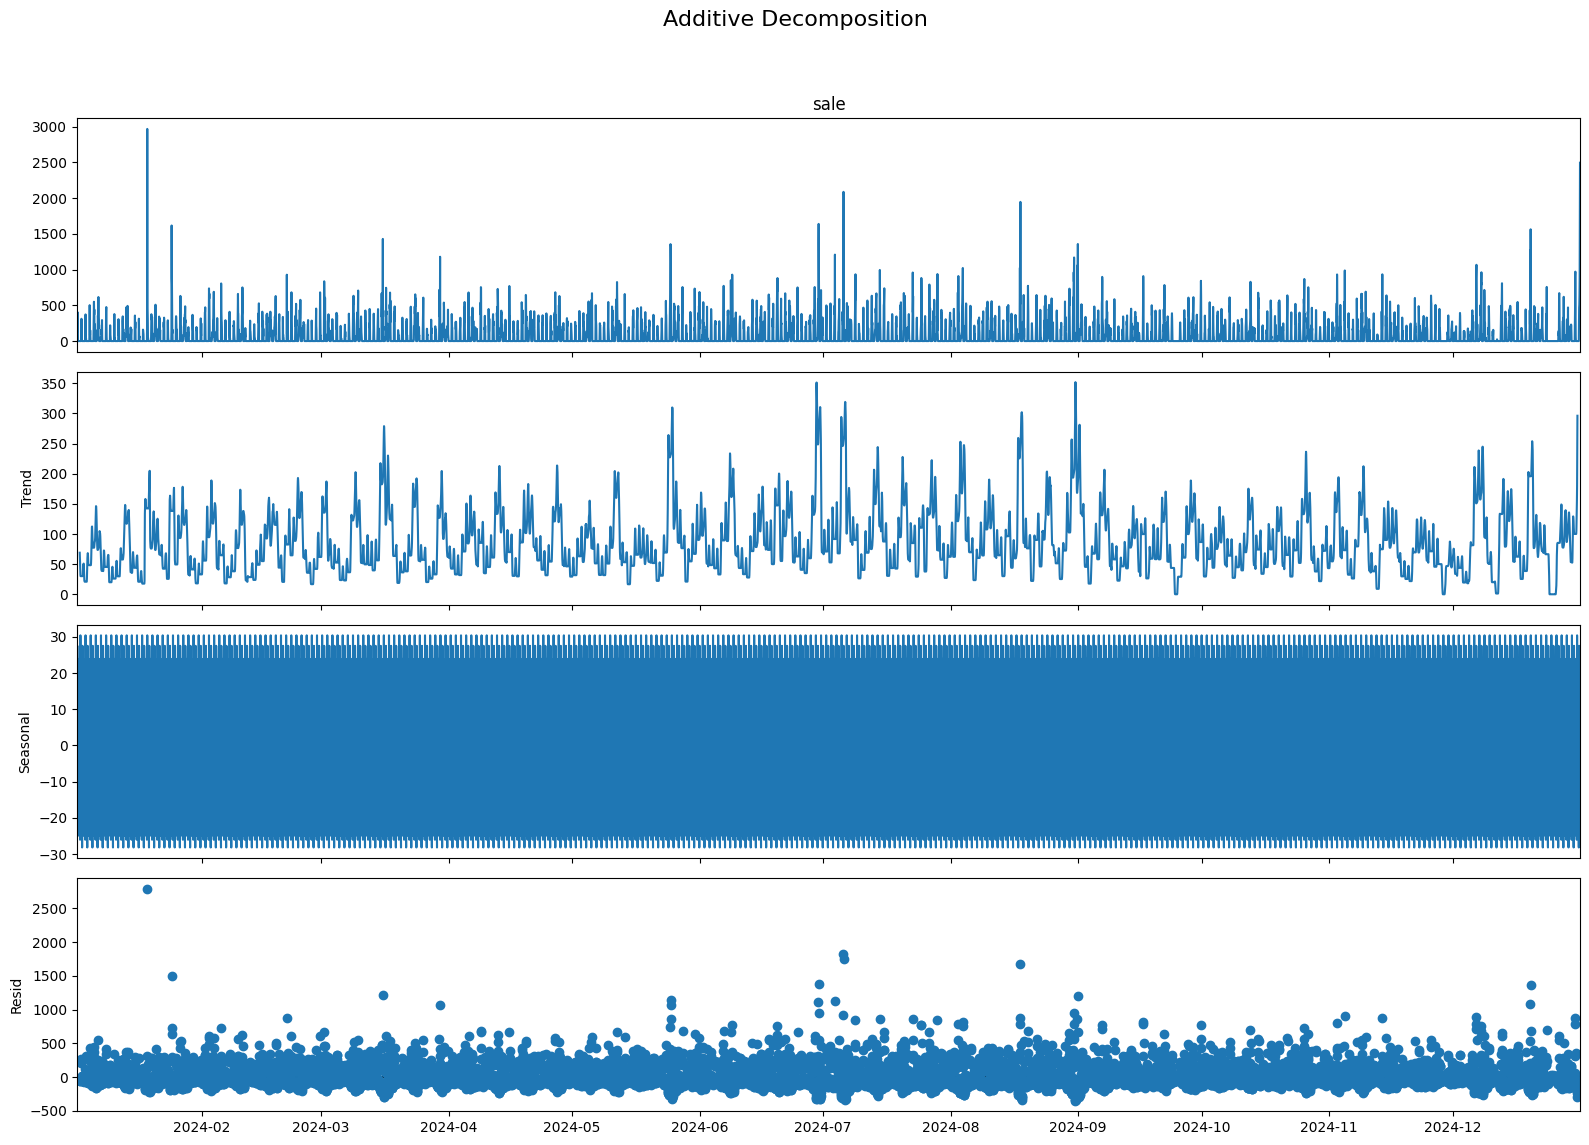

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

additive_decomposition = seasonal_decompose(alc_sales_resampled['sale'], model='additive', period=30)

plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

[]

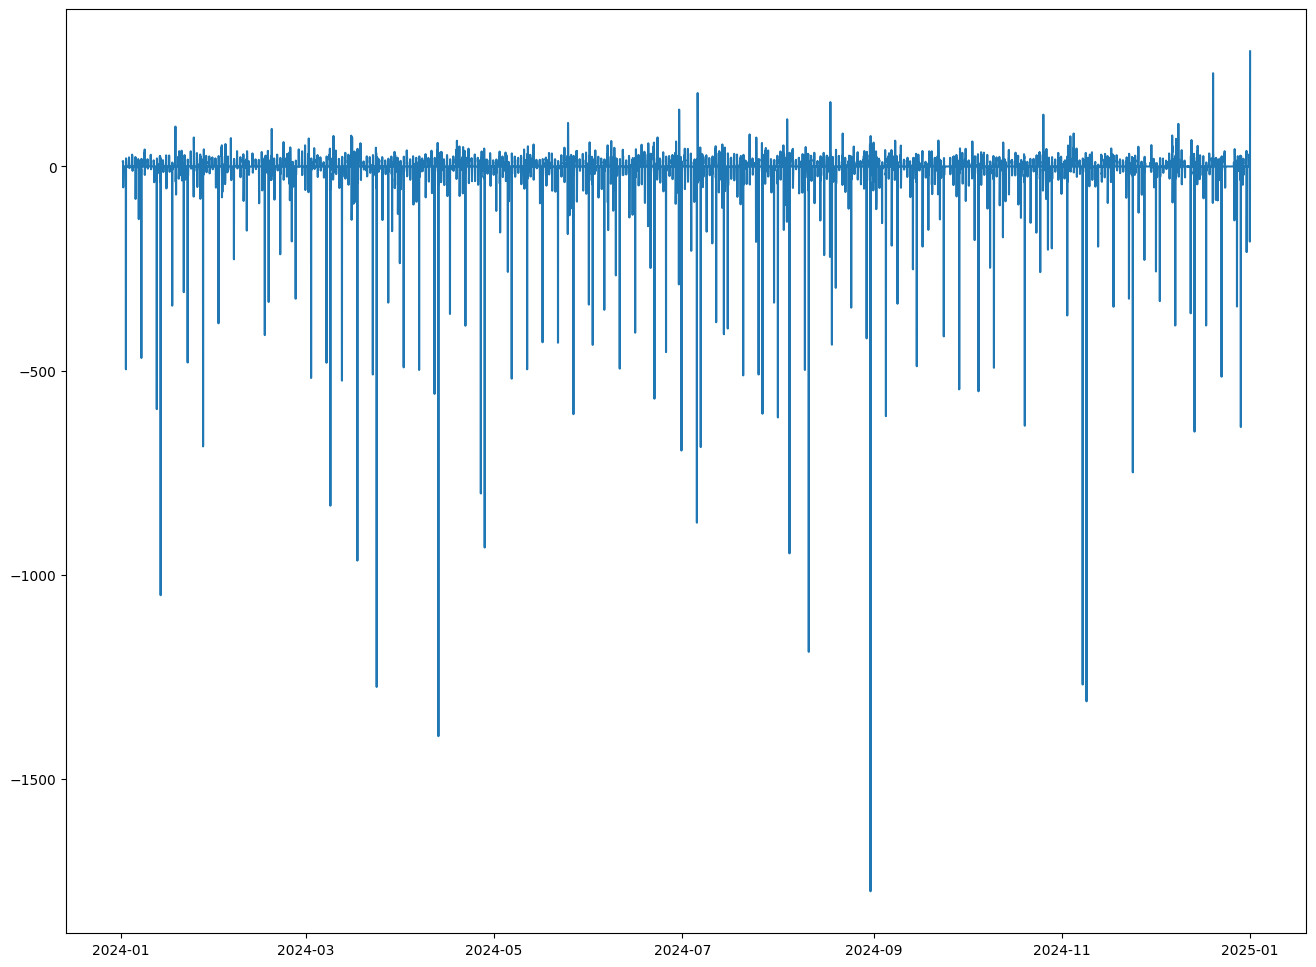

In [5]:
deseasonalized = alc_sales_resampled['sale'].values / additive_decomposition.seasonal
plt.plot(deseasonalized)
plt.plot()

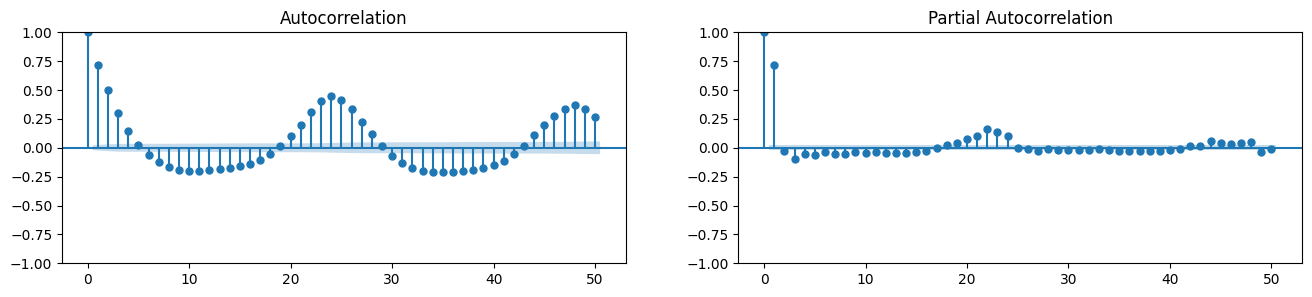

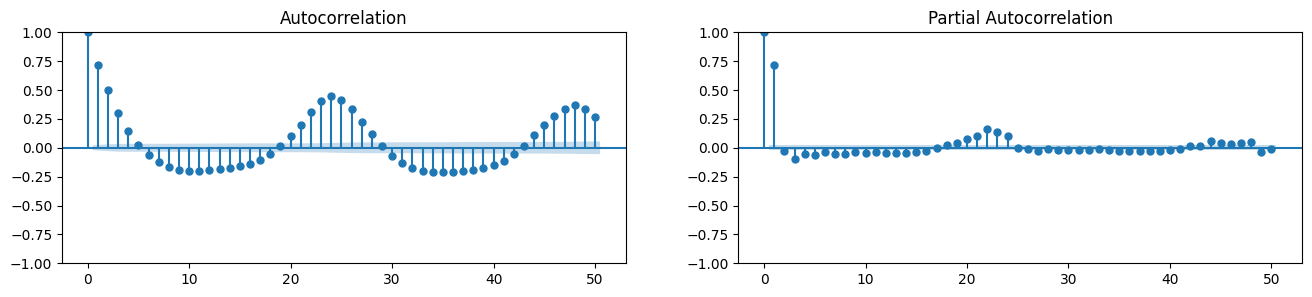

In [6]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(alc_sales_resampled['sale'].tolist(), lags=50, ax=axes[0])
plot_pacf(alc_sales_resampled['sale'].tolist(), lags=50, ax=axes[1])